<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Xander Gallegos, Andre Gonzalez.

**Fecha:** 6 de febrero de 2024.

**Expediente** : 737989, 739922.
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: <a href=https://github.com/xagallegos/ProyectoConjunto_XGallegos_AYGonzales>ProyectoConjunto_XGallegos_AYGonzales</a>

# Tarea 2: Clase 5

## Enunciado de tarea

Para ejemplo estudiado en esta clase data WWWUsage.csv probar lo siguiente:
1. Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta.
2. Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.
3. Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado, para el siguiente conjunto de datos con estacionalidad:
```
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
```
4. Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos, cómo en la siguiente gráfica:
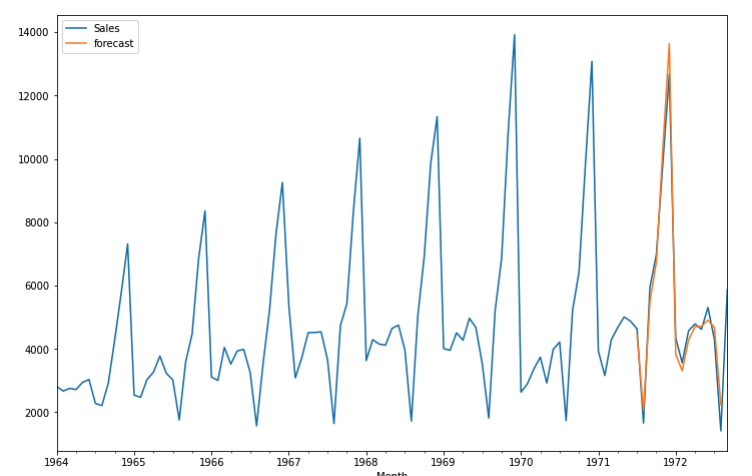

Código de solución estudiante 1: Xander Gallegos

In [ ]:
# Código de solución estudiante 1
.
.
.
.


Código de solución estudiante 2 : Andre Gonzalez

### 1

In [1]:
# Código de solución estudiante 2 
import requests
from io import BytesIO
from datetime import datetime
import pandas as pd

from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('WWWusage.csv', names=[ 'values'], header=0)
data.index = data.index.droplevel()
data

,values
1,88
2,84
3,85
4,85
5,84
...,...
96,222
97,228
98,226
99,222


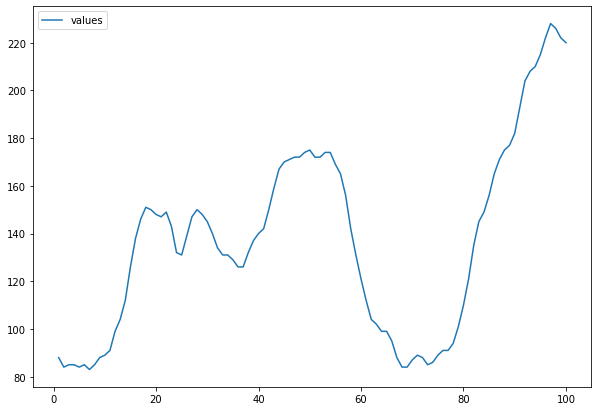

In [3]:
data.plot(figsize=(10,7))
plt.show()

In [4]:
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()
    
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [5]:
#Lo primero que hacemos es usar la funcion para comprobar si la serie es estacionaria
adf_test(data)

Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


In [6]:
# Se hace estacionaria con la diferenciacion
diff1_values = data.diff().dropna()

adf_test(diff1_values)

Results of Dickey-Fuller Test:
Test Statistic                 -2.722238
p-value                         0.070268
#Lags Used                      2.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


In [7]:

train_split = diff1_values.iloc[:int(len(data) * 0.6)]
val_split = diff1_values.iloc[int(len(data) * 0.6):int(len(data) * 0.8)]
test_split = diff1_values.iloc[int(len(data) * 0.8):]


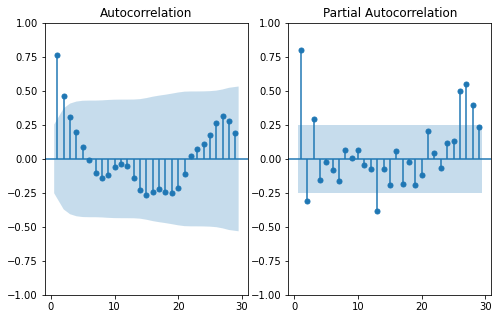

In [8]:
# Graficamos ACF y PACF
plot_acf_pacf(train_split, {'lags':29})

En base a la gráfica podemos ver que en el PACF tenemos 3 puntos significativos por lo tanto el valor de **AR** o **p=3**, al ser la primera diferenciacion sería **i** o **d=1** y en la funcion de autocorrelacion podemos notar una caida exponencial por lo tanto tendría un valor **MA** o **q=0**, por lo tanto **ARIMA(3,1,0)**.

In [9]:
# Por lo tanto el modelo sería
arima1 = ARIMA(train_split, order=(3, 1, 0))
model1 = arima1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   60
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -155.326
Date:                Tue, 06 Feb 2024   AIC                            318.652
Time:                        01:07:41   BIC                            326.963
Sample:                             0   HQIC                           321.896
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2414      0.145      1.669      0.095      -0.042       0.525
ar.L2         -0.4112      0.113     -3.640      0.000      -0.633      -0.190
ar.L3          0.0264      0.152      0.174      0.8

Podemos ver que el AIC y BIC son menores a los vistos en clase y recordando la clase se vio que entre más bajo es mejor.

### 2 

Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.


In [10]:
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data))
data_scaled

,0
0,0.034483
1,0.006897
2,0.013793
3,0.013793
4,0.006897
...,...
95,0.958621
96,1.000000
97,0.986207
98,0.958621


In [11]:
adf_test(data_scaled)

Results of Dickey-Fuller Test:
Test Statistic                 -2.464240
p-value                         0.124419
#Lags Used                      3.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary


In [12]:
diff1_values = data_scaled.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = data_scaled.diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.722238
p-value                         0.070268
#Lags Used                      2.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -9.929762e+00
p-value                        2.843429e-17
#Lags Used                     1.000000e+00
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64
Stationary


In [13]:
#Separamos nuestros datos en train, val y test
train_split_scaled = diff1_values.iloc[:int(len(data_scaled) * 0.6)]
val_split_scaled = diff1_values.iloc[int(len(data_scaled) * 0.6):int(len(data) * 0.8)]
test_split_scaled = diff1_values.iloc[int(len(data_scaled) * 0.8):]

train_split_scaled2 = diff2_values.iloc[:int(len(data_scaled) * 0.6)]
val_split_scaled2 = diff2_values.iloc[int(len(data_scaled) * 0.6):int(len(data) * 0.8)]
test_split_scaled2 = diff2_values.iloc[int(len(data_scaled) * 0.8):]

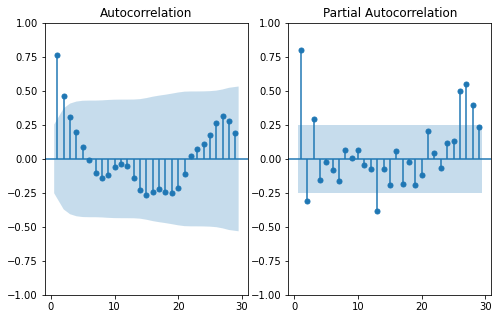

In [14]:
plot_acf_pacf(train_split_scaled, {'lags':29})

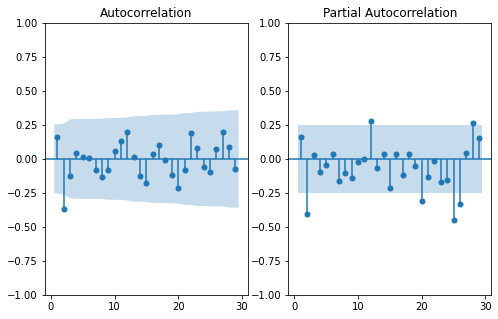

In [15]:
plot_acf_pacf(train_split_scaled2, {'lags':29})

Las gráficas son muy parecidas a las anteriores, por lo tanto usaré el mismo modelo que se creó en la parte 1.

In [16]:
arima1_1= ARIMA(train_split_scaled, order=(3, 1, 0))
model1_1 = arima1_1.fit()
print(model1_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                   60
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 138.301
Date:                Tue, 06 Feb 2024   AIC                           -268.602
Time:                        01:07:42   BIC                           -260.292
Sample:                             0   HQIC                          -265.358
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2415      0.145      1.670      0.095      -0.042       0.525
ar.L2         -0.4114      0.113     -3.643      0.000      -0.633      -0.190
ar.L3          0.0270      0.152      0.178      0.8

Ahora comprobemos con diferenciacion de dos en base a las gráficas

In [17]:
# USare ARIMA(p=2, d=2, q=2)
ar = (0, 1) 
ma = (0, 1) 

arima_model2 = ARIMA(data_scaled, order=(ar, 2, ma))
model2 = arima_model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                  100
Model:             ARIMA([2], 2, [2])   Log Likelihood                 230.889
Date:                Tue, 06 Feb 2024   AIC                           -455.779
Time:                        01:07:42   BIC                           -448.024
Sample:                             0   HQIC                          -452.642
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.4587      0.218     -2.102      0.036      -0.886      -0.031
ma.L2          0.0670      0.254      0.264      0.792      -0.432       0.566
sigma2         0.0005   8.64e-05      6.131      0.0

Podemos ver que el la log likelihood mejora muchisimo.

### 3

Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado, para el siguiente conjunto de datos con estacionalidad:



In [30]:
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
data2.head()

,air,time,t
1949-01-01,112,1949.000000,1.0
1949-02-01,118,1949.083374,2.0
1949-03-01,132,1949.166626,3.0
1949-04-01,129,1949.250000,4.0
1949-05-01,121,1949.333374,5.0


In [31]:
data2 = data2[["air"]]

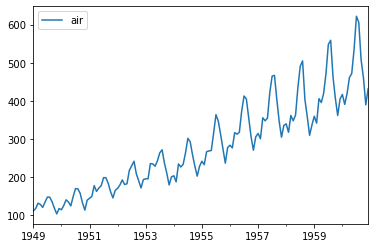

In [32]:
data2.plot()
plt.show()

Podemos ver que hay una estacionalidad por los picos

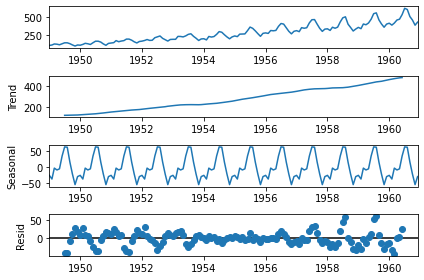

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(data2, model="additive")
decompose_data.plot();

In [34]:
diff1_values = data2.diff().dropna()

adf_test(diff1_values)

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Non-stationary


In [35]:
train_split = diff1_values.iloc[:int(len(data2) * 0.6)]
val_split = diff1_values.iloc[int(len(data2) * 0.6):int(len(data2) * 0.8)]
test_split = diff1_values.iloc[int(len(data2) * 0.8):]

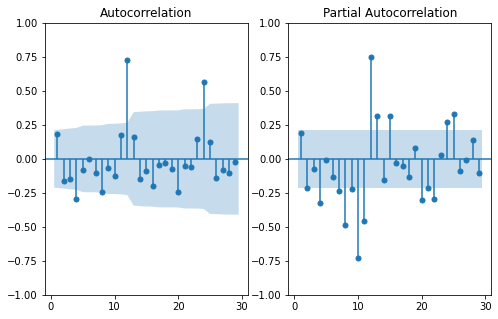

In [36]:
plot_acf_pacf(train_split, {'lags':29})

In [38]:
model = sm.tsa.statespace.SARIMAX(data2, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                air   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.149
Date:                            Tue, 06 Feb 2024   AIC                           1022.299
Time:                                    01:15:12   BIC                           1036.675
Sample:                                01-01-1949   HQIC                          1028.140
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1272      0.356     -0.358      0.721      -0.825       0.570
ma.L1         -0.2148      0.325   

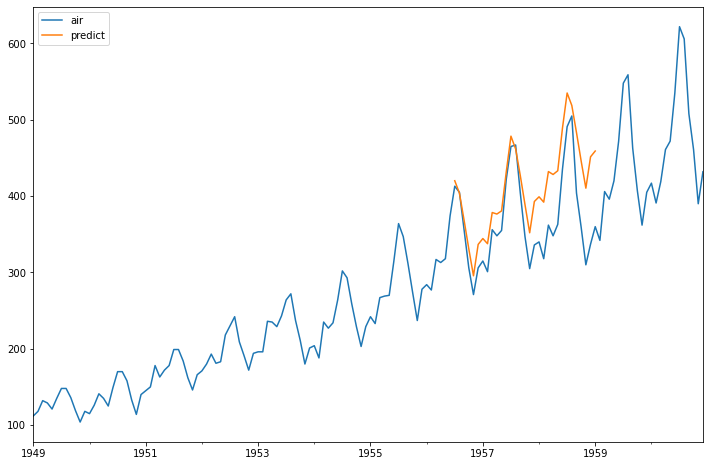

In [26]:
data2['predict'] = results.predict(start=90,end=120,dynamic=True)
data2[['air','predict']].plot(figsize=(12,8))
plt.show()

### 4

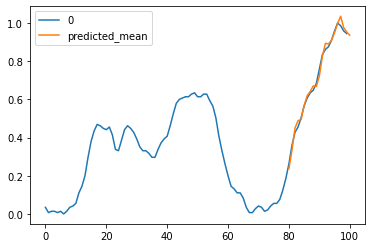

In [27]:
y_h = model2.predict(start=80, end=100, dynamic=False).to_frame()

ax = data_scaled.plot()

y_h.plot(ax=ax);

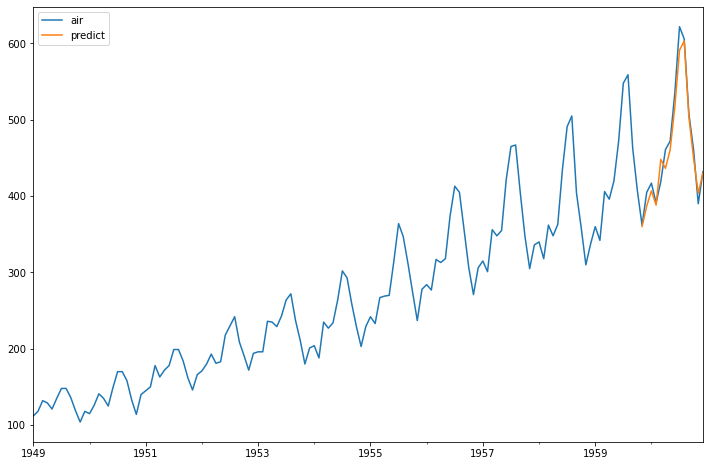

In [28]:
data2['predict'] = results.predict(start = 130, end = 150, dynamic= True)  
data2[['air', 'predict']].plot(figsize=(12, 8));